In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
local = False
if local==True: sys.path.insert(1, '/Users/user/Documents/MeerKAT/meerpower/meerpower')
if local==False: sys.path.insert(1, '/idia/projects/hi_im/meerpower/meerpower')
import Init
import plot

In [2]:
# Read-in level6 MeerKAT data:
if local==True: filestem = '/Users/user/Documents/MeerKAT/meerpower/localdata/'
if local==False: filestem = '/idia/users/jywang/MeerKLASS/calibration2021/level6/0.3/sigma4_count40/re_cali1_round5/'
map_file = filestem + 'Nscan961_Tsky_cube_p0.3d_sigma4.0_iter2.fits'
MKmap,w_HI,W_HI,counts_HI,dims,ra,dec,nu,wproj = Init.ReadIn(map_file)

### Initialise some fiducial cosmology and survey parameters:
import cosmo
nu_21cm = 1420.405751 #MHz
zeff = (nu_21cm/np.median(nu)) - 1 # Effective redshift (redshift of median frequency)
cosmo.SetCosmology(builtincosmo='Planck18',z=zeff,UseCLASS=True)
Pmod = cosmo.GetModelPk(zeff,kmax=25,UseCLASS=True) # high-kmax needed for large k-modes in NGP alisasing correction
f = cosmo.f(zeff)
sig_v = 0
b_HI = 1.5
b_g = 1.6 # tuned by eye in GAMA auto-corr
OmegaHIbHI = 0.85e-3 # MKxWiggleZ constraint
OmegaHI = OmegaHIbHI/b_HI
import HItools
import telescope
Tbar = HItools.Tbar(zeff,OmegaHI)
D_dish = 13.5 # Dish-diameter [metres]
theta_FWHM,R_beam = telescope.getbeampars(D_dish,np.median(nu))
window = 'ngp'
compensate = True
interlace = True

### Remove incomplete LoS pixels from maps:
MKmap,w_HI,W_HI,counts_HI = Init.FilterIncompleteLoS(MKmap,w_HI,W_HI,counts_HI)

### Trim map edges (can fine-tune boarders if needed):
raminMK,ramaxMK = 334,357
decminMK,decmaxMK = -35,-26.5
MKmap,w_HI,W_HI,counts_HI = Init.MapTrim(ra,dec,MKmap,w_HI,W_HI,counts_HI,ramin=raminMK,ramax=ramaxMK,decmin=decminMK,decmax=decmaxMK)

### Use unit weights for mocks:
w_HI = np.ones(np.shape(MKmap)) # Not factorised along LoS so will add rank if used in foreground cleaning in current form


In [3]:
import grid # use this for going from (ra,dec,freq)->(x,y,z) Cartesian-comoving grid
cell2vox_factor = 1.5 # increase for lower resolution FFT Cartesian grid
Np = 5
nxmap,nymap,nzmap = np.shape(MKmap)
ndim_rg = int(nxmap/cell2vox_factor),int(nymap/cell2vox_factor),int(nzmap/cell2vox_factor)
dims_rg,dims0_rg = grid.comoving_dims(ra,dec,nu,wproj,ndim_rg,W=W_HI)
lx,ly,lz,nx_rg,ny_rg,nz_rg = dims_rg

# Grid uncut pixels to obtain binary mask in comoving space:
raminGAMA,ramaxGAMA = 339,351
decminGAMA,decmaxGAMA = -35,-30
ra_p,dec_p,nu_p = grid.SkyPixelParticles(ra,dec,nu,wproj,Np=Np)
MKcutmask = (ra_p>raminMK) & (ra_p<ramaxMK) & (dec_p>decminMK) & (dec_p<decmaxMK)
xp,yp,zp = grid.SkyCoordtoCartesian(ra_p[MKcutmask],dec_p[MKcutmask],HItools.Freq2Red(nu_p[MKcutmask]),ramean_arr=ra,decmean_arr=dec,doTile=False)
null,W01_HI_rg,counts = grid.mesh(xp,yp,zp,dims=dims0_rg,window='ngp',compensate=False,interlace=False,verbose=False)
GAMAcutmask = (ra_p>raminGAMA) & (ra_p<ramaxGAMA) & (dec_p>decminGAMA) & (dec_p<decmaxGAMA)
xp,yp,zp = grid.SkyCoordtoCartesian(ra_p[GAMAcutmask],dec_p[GAMAcutmask],HItools.Freq2Red(nu_p[GAMAcutmask]),ramean_arr=ra,decmean_arr=dec,doTile=False)
null,W01_g_rg,counts = grid.mesh(xp,yp,zp,dims=dims0_rg,window='ngp',compensate=False,interlace=False,verbose=False)

# Create tapering to apply to Cartesian fields
# - needs to taper a conical footprint so currently using a technique that Gaussian smooths inwards from the empty edges:
doTaper = True # Implement apodisation window functions to apply to maps and weights to taper edges
if doTaper==True:
    # Gaussian smoothing from empty edges:
    taper_HI = np.copy(W01_HI_rg)
    taper_g = np.copy(W01_g_rg)
    from scipy.ndimage import gaussian_filter
    for i in range(8):
        taper_HI = gaussian_filter(taper_HI, sigma=1, mode='reflect')
        taper_HI[W01_HI_rg==0] = 0
        taper_g = gaussian_filter(taper_g, sigma=1, mode='reflect')
        taper_g[W01_g_rg==0] = 0

if doTaper==False: taper_HI,taper_g = 1,1
# Multiply tapering window by all galaxy fields that undergo Fourier transforms
W01_g_rg = taper_g*W01_g_rg
w_g_rg = np.ones((nx_rg,ny_rg,nz_rg))
w_g_rg = taper_g*w_g_rg
# HI window and weights:
ra_p,dec_p,nu_p,pixvals = grid.SkyPixelParticles(ra,dec,nu,wproj,map=w_HI,W=W_HI,Np=Np)
xp,yp,zp = grid.SkyCoordtoCartesian(ra_p,dec_p,HItools.Freq2Red(nu_p),ramean_arr=ra,decmean_arr=dec,doTile=False)
w_HI_rg,W_fft,counts = grid.mesh(xp,yp,zp,pixvals,dims0_rg,window,compensate,interlace,verbose=False)
# Multiply tapering window by all weights and window
w_HI_rg,W01_HI_rg = taper_HI*w_HI_rg,taper_HI*W01_HI_rg


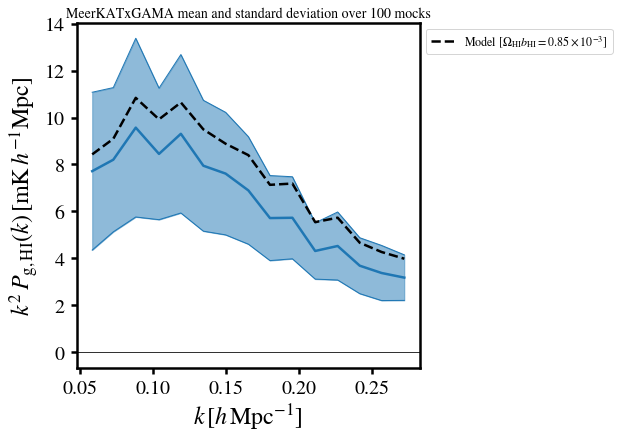

In [4]:
import power # All power spectrum calculations performed in this script
import model
from scipy import signal
nkbin = 15
kmin,kmax = 0.05,0.28
kbins = np.linspace(kmin,kmax,nkbin+1) # k-bin edges [using linear binning]
nx,ny,nz = np.shape(MKmap)
kcuts = None # no cuts to k-space for power spectra estimation

'''
Nmock = 100
Pk_g,Pk_HI,Pk_X = np.zeros((Nmock,nkbin)),np.zeros((Nmock,nkbin)),np.zeros((Nmock,nkbin))
for i in range(Nmock):
    print(i)
    # Read-in GAMA mock galaxies:
    ra_g,dec_g,z_g = np.load('/idia/projects/hi_im/meerpower/2021Lband/mocks/mockGAMAcat_%s.npy'%i)
    ### Grid GAMA mock galaxies and measure power:
    xp,yp,zp = grid.SkyCoordtoCartesian(ra_g,dec_g,z_g,ramean_arr=ra,decmean_arr=dec,doTile=False)
    n_g_rg,W_fft,counts = grid.mesh(xp,yp,zp,dims=dims0_rg,window=window,compensate=compensate,interlace=interlace,verbose=False)
    n_g_rg = taper_g*n_g_rg
    Pk_g[i],k,nmodes = power.Pk(n_g_rg,n_g_rg,dims_rg,kbins,corrtype='Galauto',w1=w_g_rg,w2=w_g_rg,W1=W01_g_rg,W2=W01_g_rg)

    # Read-in HI IM mock:
    MKmap = np.load('/idia/projects/hi_im/meerpower/2021Lband/mocks/dT_HI_p0.3d_wBeam_%s.npy'%i)
    # Resample HI IM mock and measure power and cross power:
    ra_p,dec_p,nu_p,pixvals = grid.SkyPixelParticles(ra,dec,nu,wproj,map=MKmap,W=W_HI,Np=Np)
    xp,yp,zp = grid.SkyCoordtoCartesian(ra_p,dec_p,HItools.Freq2Red(nu_p),ramean_arr=ra,decmean_arr=dec,doTile=False)
    MKmap_rg,W_fft,counts = grid.mesh(xp,yp,zp,pixvals,dims0_rg,window,compensate,interlace,verbose=False)
    MKmap_rg = taper_HI*MKmap_rg # multiply tapering window by HI map
    Pk_HI[i],k,nmodes = power.Pk(MKmap_rg,MKmap_rg,dims_rg,kbins,corrtype='HIauto',w1=w_HI_rg,w2=w_HI_rg,W1=W01_HI_rg,W2=W01_HI_rg,kcuts=kcuts)
    Pk_X[i],k,nmodes = power.Pk(MKmap_rg,n_g_rg,dims_rg,kbins,corrtype='Cross',w1=w_HI_rg,w2=W01_g_rg,W1=W01_HI_rg,W2=W01_g_rg,kcuts=kcuts)

np.save('/idia/projects/hi_im/meerpower/2021Lband/mocks/PksFromMocks',[Pk_HI,Pk_g,Pk_X,k])
'''
Pk_HI,Pk_g,Pk_X,k = np.load('/idia/projects/hi_im/meerpower/2021Lband/mocks/PksFromMocks.npy',allow_pickle=True)
Nmock = np.shape(Pk_HI)[0]
norm = k**2
plt.plot(k,norm*np.mean(Pk_X,0),color='tab:blue')
plt.plot(k,norm*(np.mean(Pk_X,0)-np.std(Pk_X,0)),lw=1,color='tab:blue')
plt.plot(k,norm*(np.mean(Pk_X,0)+np.std(Pk_X,0)),lw=1,color='tab:blue')
plt.fill_between(k,norm*(np.mean(Pk_X,0)-np.std(Pk_X,0)),norm*(np.mean(Pk_X,0)+np.std(Pk_X,0)), alpha=0.5, color='tab:blue')
#plt.errorbar(k,norm*np.mean(Pk_X,0),norm*np.std(Pk_X,0),ls='none',marker='o')

# Model power spectrum:
dpix = 0.3
d_c = cosmo.d_com(HItools.Freq2Red(np.min(nu)))
s_pix = d_c * np.radians(dpix)
s_para = np.mean( cosmo.d_com(HItools.Freq2Red(nu[:-1])) - cosmo.d_com(HItools.Freq2Red(nu[1:])) )
pkmod,k = model.PkMod(Pmod,dims_rg,kbins,b_HI,b_g,f,sig_v,Tbar1=Tbar,Tbar2=1,r=1,R_beam1=R_beam,R_beam2=0,w1=W01_HI_rg,w2=W01_g_rg,W1=W01_HI_rg,W2=W01_g_rg,s_pix=s_pix,s_para=s_para,interpkbins=True,MatterRSDs=False,gridinterp=True)[0:2]
plt.plot(k,norm*pkmod,color='black',ls='--',label=r'Model [$\Omega_{\rm HI}b_{\rm HI} = %s \times 10^{-3}]$'%np.round(OmegaHI*b_HI*1e3,2))
if norm[0]==1.0: plt.loglog()
plt.legend(fontsize=12,loc='upper left',bbox_to_anchor=[1,1])
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
if norm[0]==1.0: plt.ylabel(r'$P_{\rm g,HI}(k)\,[{\rm mK}\,h^{-3}{\rm Mpc}^{3}]$')
else: plt.ylabel(r'$k^2\,P_{\rm g,HI}(k)\,[{\rm mK}\,h^{-1}{\rm Mpc}]$')
plt.axhline(0,lw=0.8,color='black')
plt.subplots_adjust(right=0.75)
plt.title(r'MeerKATxGAMA mean and standard deviation over %s mocks'%Nmock,fontsize=14)
plt.show()